<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

# O cenário da cidade do Rio de Janeiro: rede escolar

- Continuando a criação de cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- Neste segundo caderno da série, ...

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

import pandas as pd

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../../..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 09/Jun/2020


## Distribuição populacional da cidade do Rio de Janeiro

Primeiramente, conforme feito anteriormente:

- posicionamos as residências;

- distribuímos os indivíduos em suas residências; e 

- posicionamos os indivíduos em torno de suas residências.

### Carregando os dados

Carregamos os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro obtidos do [Landscan](https://landscan.ornl.gov), mudando para 0 o valor das células com -1.

In [5]:
landscan_rio = np.load('../../../../dados/RJ/cidade_rj/dados_estatisticos/LandScan.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

Carregamos os dados de escolas por quilômetro quadrado da cidade do Rio de Janeiro, obtidos do [IPP/Data Rio](https://www.data.rio/datasets/escolas-municipais)

In [6]:
escolas_municipais = np.load('../../../../dados/RJ/cidade_rj/dados_estatisticos/Municipais.npy').astype(int)

### Visualização em escala logarítmica

Visualizamos 

$$ ln( 1 + \textrm{população})
$$

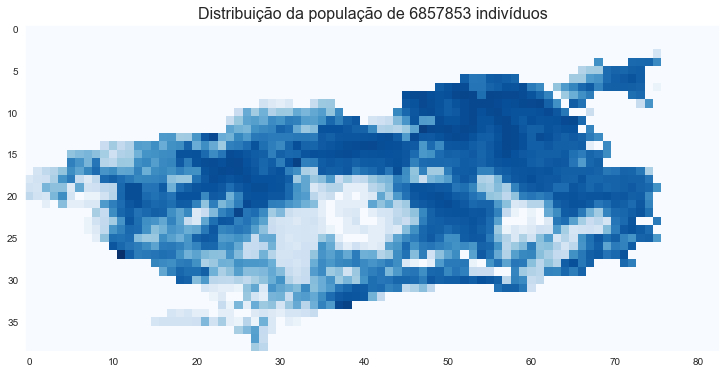

In [7]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + landscan_rio), cmap='Blues', interpolation='none')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

## Rede residencial

Montamos a rede residencial como antes.

O importante para a montagem da rede de empresas não é a rede residencial em si, apenas a localização dos indivíduos feita na construção da rede residencial.

### Reduzindo a população

Com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator. 

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [8]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])
pop_por_blocos = (landscan_rio/100).astype(int)

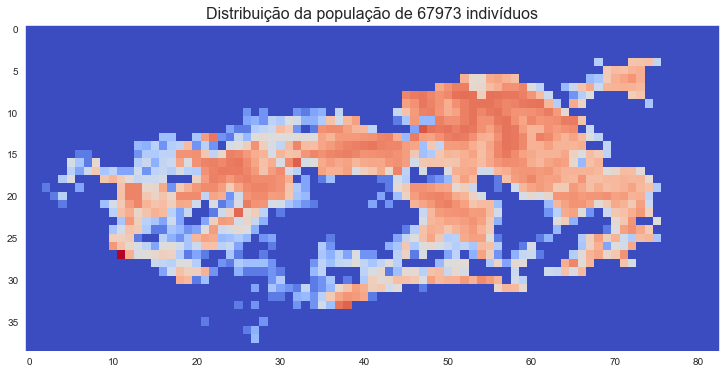

In [9]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + pop_por_blocos), cmap='coolwarm', interpolation='none')
#plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição da população de {pop_por_blocos.sum()} indivíduos', fontsize=16)
plt.show()

### Distribuindo e alocando os indivíduos e as suas residências

In [10]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_blocos, censo_residencial)

CPU times: user 1.09 s, sys: 25.1 ms, total: 1.11 s
Wall time: 1.12 s


In [11]:
pop_blocos_indices[-1]

67973

### Gerando o grafo da rede residencial

In [12]:
%%time
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(pop_por_blocos), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos if i < j])

CPU times: user 430 ms, sys: 31.6 ms, total: 461 ms
Wall time: 707 ms


### Viualização

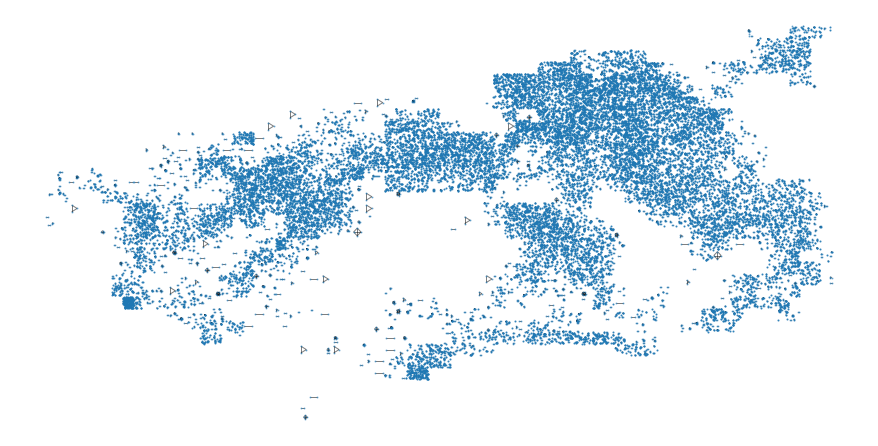

CPU times: user 2.41 s, sys: 121 ms, total: 2.53 s
Wall time: 2.45 s


In [13]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Rede escolar

Na construção da rede escolar, a ideia é fazer os seguintes passos:

- Temos as distribuições geolocalizadas das escolas.

- A partir do censo de idade populacional, determinar a parte da população a ser alocada nas escolas

- Para alocar a população nas escolas: Calculamos a distância de cada individuo para todas as escolas, e tomamos as 3 escolas mais próximas. Feito isso é selecionao uma das 3 escolas de maneira aleatória

- Para o cenário múltiplo de `Pop350`, fazemos uma redução proporcional no número de escolas com a função `random.choices`

### Redução no número de escolas

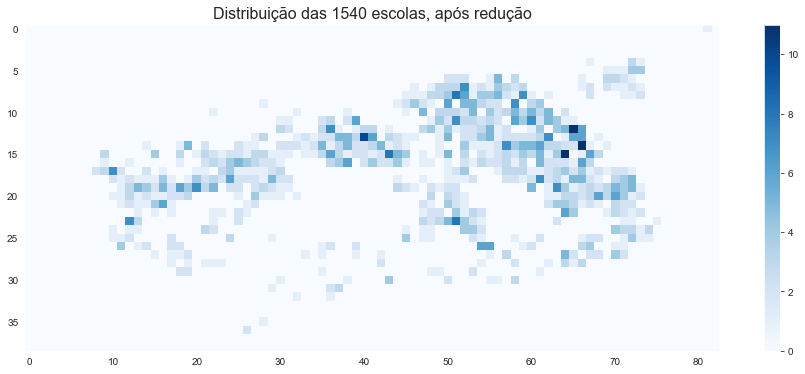

In [14]:
plt.figure(figsize=(16,6))
plt.imshow(escolas_municipais, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {escolas_municipais.sum()} escolas, após redução', fontsize=16)
plt.show()

In [15]:
rng_escolas = np.arange(np.prod(np.shape(escolas_municipais)))
weight_escolas = (escolas_municipais/np.sum(escolas_municipais)).flatten()

index_escolas = rng_escolas[weight_escolas != 0]  ## Guardando o indice das escolas
weight_escolas = weight_escolas[weight_escolas != 0]

In [16]:
## Escolhendo as escolas
esc_escolha = np.array(random.choices(index_escolas, weight_escolas, k = np.floor(np.sum(escolas_municipais*2/100)).astype(int)))

In [17]:
# Retornando as escolas à matriz 83x39
row_escolas = np.floor(esc_escolha/83)
col_escolas = np.mod(esc_escolha,83)
escolas_municipais_por_blocos = np.zeros((39,83))
for i,j in zip(row_escolas,col_escolas):
    escolas_municipais_por_blocos[int(i)][j] += 1

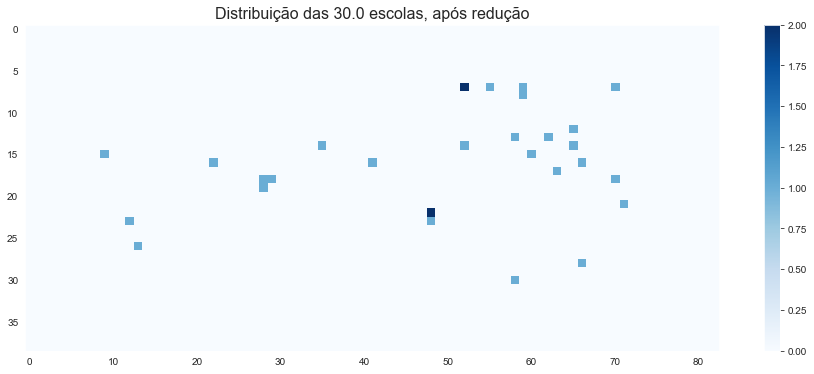

In [18]:
plt.figure(figsize=(16,6))
plt.imshow(escolas_municipais_por_blocos, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {escolas_municipais_por_blocos.sum()} escolas, após redução', fontsize=16)
plt.show()

## Distribuição das idades

## Pirâmide etária do rio de Janeiro

- Como as pirâmides etárias do Rio de Janeiro e do Brasil são razoavelmente diferentes, vamos trabalhar com os dados do Rio.

- Inicialmente, consideramos a pirâmide populacional da cidade do Rio de Janeiro disponível na [Tabela 6407 do IBGE - População residente, por sexo e grupo de idade](https://sidra.ibge.gov.br/tabela/6407#resultado), que infelizemente não diferencia faixas acima de 65 anos:


| Total | 100,0 |
| --- | --- |
| 0 anos  | 9,4 |
| 1 anos  | 9,4 |
| 2 anos  | 9,4 |
| 3 anos  | 9,4 |
| 4 anos  | 9,4 |
| 5 anos  | 9,4 |
| 6 anos  | 9,4 |
| 7 anos  | 9,4 |
| 8 anos  | 9,4 |
| 9 anos  | 9,4 |
| 10 anos | 9,4 |
| 11 anos  | 9,4 |
| 12 anos  | 9,4 |
| 13 anos  | 9,4 |
| 14 anos  | 9,4 |
| 15 anos  | 9,4 |
| 16 anos  | 9,4 |
| 17 anos  | 9,4 |
| 18 anos  | 9,4 |
| 19 anos  | 9,4 |
| 20 anos  | 9,4 |
| 21 anos  | 9,4 |
| 22 anos  | 9,4 |
| 23 anos  | 9,4 |
| 24 anos  | 9,4 |
| 25 a 29 anos | 9,4 |
| 30 a 34 anos| 11,9 |
| 35 a 39 anos | 13,2 |
| 40 a 44 anos | 15,5 |
| 45 e 49 anos | 14,2 |
| 50 a 54 anos | 14,0 |
| 55 a 59 | 22,0 |
| 60 a 64 anos | 15,5 |
| 65 a 69 anos | 14,2 |
| 70 a 74 anos | 14,0 |
| 75 a 79 anos | 14,0 |
| 80 ou 84 anos | 22,0 |
| 85 ou 89 anos | 22,0 |
| 90 ou 94 anos | 22,0 |
| 95 ou 99 anos | 22,0 |
| 100 ou mais | 22,0 |

In [19]:
piramide_etaria = pd.read_csv('../../../../dados/RJ/cidade_rj/dados_estatisticos/piramide_etaria_MRJ.csv')

In [82]:
piramide_etaria

,total,0,1,2,3,4,5,6,7,8,...,55 a 59,60 a 64,65 a 69,70 a 74,75 a 79,80 a 84,85 a 89,90 a 94,95 a 99,100
0,6320446,72828,72657,71632,72365,74550,77218,76536,77789,78054,...,349675,279122,206203,170853,129430,90230,43786,16205,4259,763


In [20]:
idades_grupos = np.array([int(p[0:2]) for p in piramide_etaria.columns[1:]])
idades_grupos[-1] = 100
idades_fracoes_grupos = piramide_etaria.iloc[0][1:].values/piramide_etaria.iloc[0][0]

idade_max = 100
print(f'Conferindo a soma das frações dos grupos de idades: {idades_fracoes_grupos.sum()}')

Conferindo a soma das frações dos grupos de idades: 1.0


In [79]:
num_pop

67973

In [81]:
np.sum(idades_fracoes_grupos[28:])

0.40774685837043784

In [71]:
idades_fracoes_grupos

array([0.0115226 , 0.01149555, 0.01133338, 0.01144935, 0.01179505,
       0.01221718, 0.01210927, 0.01230752, 0.01234944, 0.01363227,
       0.01532977, 0.0145784 , 0.01472127, 0.0145072 , 0.01468203,
       0.01500954, 0.01454787, 0.01444139, 0.01460467, 0.01483281,
       0.01583876, 0.015909  , 0.01618066, 0.01580363, 0.01675388,
       0.08719369, 0.08297753, 0.07412942, 0.06956645, 0.06910841,
       0.06488925, 0.05532442, 0.04416176, 0.03262475, 0.02703179,
       0.02047799, 0.01427589, 0.00692768, 0.0025639 , 0.00067384,
       0.00012072])

## População ativa na educação básica

In [21]:
# censo_fracoes = np.array([0.15079769082144653,  # 0 a 9 anos
#                  0.17906470565542282,  # 10 a 19 anos
#                  0.18007108135150324,  # 20 a 29 anos
#                  0.15534569934620965,  # 30 a 39 anos
#                  0.13023309451263393,  # 40 a 49 anos
#                  0.09654553673621215,  # 50 a 59 anos
#                  0.059499784853198616, # 60 a 69 anos
#                  0.033053176013799715, # 70 a 79 anos
#                  0.015389230709573343  # 80 ou mais
#                 ])

In [22]:
num_pop = pop_por_blocos.sum()
print(num_pop)

67973


In [ ]:
num_pop*(c)

In [33]:
for j in range(1,num_tam_res+1):
    # seleciona residências com j indivíduos (res[0]=[])
    res[j] = [r for r in res_individuos if len(r) == j]

In [25]:
piramide_etaria.columns[1:21]

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19'],
      dtype='object')

In [26]:
num_pop_0a19 = int(num_pop*np.sum(idades_fracoes_grupos[0:20])) # consideramos apenas de 0 a 18 anos 
print(f'População em idade ativa: {num_pop_0a19}')

População em idade ativa: 18180


In [119]:
p_esc_a_idades_grupos = np.array([0, 2, 3, 6, 11, 15, 17, 19, 20, 100])
p_esc_a_idades_fracoes_grupos = np.array([0, .4, .8, .95, .95, .95, .95, .75, 0])

In [120]:
num_tam_res = len(censo_residencial)
distrib_tam_por_res = np.array([len(res_individuos[k]) for k in range(len(res_individuos))])
distrib_res = np.array([len(distrib_tam_por_res[distrib_tam_por_res == j]) for j in range(1,num_tam_res+1)])

In [121]:
res = (num_tam_res+1)*[[]]
for j in range(1,num_tam_res+1):
    res[j] = [r for r in res_individuos if len(r) == j]
res_2b = random.sample(res[2], k=int(0.1*len(res[2])))
res_2a = [r for r in res[2] if r not in res_2b]
res_3mais = []
for res_k in res[3:]:
    res_3mais += res_k

In [122]:
p_esc_a_idades_fracoes = list()
for j in range(len(p_esc_a_idades_grupos)-1):
    p_esc_a_idades_fracoes += (p_esc_a_idades_grupos[j+1] - p_esc_a_idades_grupos[j]) \
        * [p_esc_a_idades_fracoes_grupos[j]]

#pea_idades_fracoes = np.array(pea_idades_fracoes)*idades_fracoes
p_esc_a_idades_fracoes = np.array(p_esc_a_idades_fracoes)
print(f'Fração da população na educação básica: {p_esc_a_idades_fracoes.sum():.1f} %')

Fração da população na educação básica: 15.9 %


In [123]:
p_esc_a_idades_fracoes

array([0.  , 0.  , 0.4 , 0.8 , 0.8 , 0.8 , 0.95, 0.95, 0.95, 0.95, 0.95,
       0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.75, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [124]:
num_ativos_escola = int(p_esc_a_idades_fracoes.sum()/100 * num_pop)
num_ativos_escola

10807

In [125]:
pop_idades = episiming.cenarios.gera_idades(67973, 8, res_individuos, idades_grupos, idades_fracoes_grupos, idade_max = 100)

/Users/macbookpro/Desktop/GitHub/covid19/episiming/cenarios.py:232: RuntimeWarning: divide by zero encountered in double_scalars
  * [idades_fracoes_grupos[-1]/(idade_max-idades_grupos[-1])]


In [126]:
pop_idades

array([58, 34, 66, ..., 50, 14, 15])

In [127]:
np.count_nonzero(pop_idades < 20)

17796

In [128]:
pessoas_por_idade = []

for idade_escolar in range(20):
    pessoas_por_idade.append(np.count_nonzero(pop_idades == idade_escolar))
    
pessoas_por_idade = np.array(pessoas_por_idade)
print(pessoas_por_idade)
np.sum(pessoas_por_idade)

[ 785  781  765  781  801  823  830  837  847  927 1033  998 1009  989
  987 1020  993  991  987  612]


17796

In [129]:
idades_na_escola_fracoes = p_esc_a_idades_fracoes[:20]

In [130]:
idades_na_escola_fracoes

array([0.  , 0.  , 0.4 , 0.8 , 0.8 , 0.8 , 0.95, 0.95, 0.95, 0.95, 0.95,
       0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.75])

In [131]:
len(idades_na_escola_fracoes) == len(pessoas_por_idade)

True

In [146]:
idades_na_escola = np.round(idades_na_escola_fracoes*pessoas_por_idade).astype(int)
np.sum(idades_na_escola)

14515

In [133]:
alunos = [np.random.choice(np.arange(len(pop_idades))[pop_idades == i], idades_na_escola[i], replace = False) for i in range(20)]  ## Guardando o indice das escolas


In [134]:
[len(a) for a in alunos]

[0,
 0,
 306,
 625,
 641,
 658,
 788,
 795,
 805,
 881,
 981,
 948,
 959,
 940,
 938,
 969,
 943,
 941,
 938,
 459]

## Alocando população escolar nas escolas

### Gerando a localização das escolas

In [135]:
pos_x_escolas_municipais = col_escolas + np.random.rand(30)
pos_y_escolas_municipais = row_escolas + np.random.rand(30)

In [136]:
pos_escolas_municipais = np.array([pos_x_escolas_municipais,pos_y_escolas_municipais]).T

In [137]:
pos_escolas_municipais

array([[65.49137372, 12.49072606],
       [66.08080674, 16.91811959],
       [58.75884385, 30.73457023],
       [63.37022991, 17.67863706],
       [48.77233413, 22.8058137 ],
       [60.84378343, 15.92320304],
       [52.6105989 ,  7.00386354],
       [71.33590126, 21.44463013],
       [66.73623096, 28.50815623],
       [35.57972471, 14.9301588 ],
       [48.34643614, 22.14580327],
       [70.53306477,  7.02968932],
       [52.73650526, 14.48888297],
       [55.962807  ,  7.67289973],
       [52.4896491 ,  7.12177664],
       [65.78351795, 14.54103518],
       [28.55024312, 18.86202499],
       [41.76603702, 16.98431123],
       [13.33874013, 26.272522  ],
       [62.59500329, 13.01030831],
       [29.54176475, 18.75336076],
       [28.99280076, 19.23607303],
       [12.9605211 , 23.51438928],
       [59.5788907 ,  7.03163696],
       [48.1427659 , 23.22976621],
       [22.64207324, 16.08862922],
       [70.99859385, 18.72697385],
       [ 9.05317236, 15.30033627],
       [58.95491117,

In [140]:
alunos_array = np.hstack(alunos)

In [141]:
pos_individuos_escolas = np.array(pos_individuos)[alunos_array]
dist_indiv_esc = [np.linalg.norm(p_i - pos_escolas_municipais, axis = 1).argsort()[:3] for p_i in pos_individuos_escolas]

In [142]:
dist_indiv_esc

[array([22, 18, 25]),
 array([24,  4, 10]),
 array([2, 8, 3]),
 array([ 0, 15, 11]),
 array([26,  1,  7]),
 array([24,  4, 10]),
 array([8, 2, 3]),
 array([20, 21, 16]),
 array([ 2, 24,  4]),
 array([24,  4, 10]),
 array([ 1,  3, 15]),
 array([16, 21, 20]),
 array([25, 16, 21]),
 array([2, 3, 5]),
 array([14,  6, 17]),
 array([ 1,  3, 15]),
 array([12, 10,  4]),
 array([ 2, 24,  4]),
 array([22, 27, 18]),
 array([24,  4, 10]),
 array([16, 21, 20]),
 array([3, 1, 8]),
 array([25, 16, 21]),
 array([20, 21, 16]),
 array([2, 8, 3]),
 array([12, 10,  4]),
 array([ 1, 26, 15]),
 array([17, 12, 14]),
 array([27, 22, 18]),
 array([24, 10,  4]),
 array([12, 28,  5]),
 array([ 1, 26,  7]),
 array([ 2,  4, 24]),
 array([2, 8, 4]),
 array([8, 2, 3]),
 array([12, 10,  4]),
 array([2, 3, 5]),
 array([ 1, 15,  3]),
 array([8, 2, 7]),
 array([ 4, 24,  2]),
 array([2, 8, 3]),
 array([5, 3, 2]),
 array([16, 21, 20]),
 array([17, 24, 10]),
 array([26,  7,  1]),
 array([24,  4, 10]),
 array([16, 21, 20]),

In [143]:
indiv_esc = [random.choices(i)[0] for i in dist_indiv_esc]

In [145]:
len(indiv_esc)

14515

In [ ]:
#indiv_esc = [random.choices(np.linalg.norm(p_i - pos_escolas_municipais, axis = 1).argsort()[:3])[0] for p_i in pos_individuos_escolas]

---